# make plots
#### 9 Dec 2025

###  notes

In [1]:
import os
os.listdir()

['make_dfs_5reps.ipynb',
 '.ipynb_checkpoints',
 'slurm-45637026.out',
 'run_5reps.sh',
 'null_all_reps.csv',
 'make_plots.ipynb',
 'vcf_stage',
 'inf_all_reps.csv']

### get started

#### import modules

In [2]:
import os

In [3]:
from tqdm.notebook import tqdm

In [4]:
import time
for i in tqdm(range(100)):
    time.sleep(0.05) # Simulate some work

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
import tsinfer
import tskit
import msprime
import tsdate

import numpy as np
import pandas as pd

import datetime as dt
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.colors import TwoSlopeNorm
import matplotlib.ticker as ticker

from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 

import itertools
from itertools import combinations

from Bio import SeqIO, AlignIO

import gzip
import csv

import subprocess, gzip, tempfile
import shutil

from concurrent.futures import ProcessPoolExecutor, as_completed
import warnings

# read in dfs

In [8]:
inf_all = pd.read_csv('inf_all_reps.csv')
inf_all

,mu,pm,rr,rep,bin,r2,kind,n_trees_sim,n_trees_inf
0,1.000000e-10,0.001,1.000000e-13,2,1,0.942182,inferred,1,3
1,1.000000e-10,0.001,1.000000e-13,2,2,0.942182,inferred,1,3
2,1.000000e-10,0.001,1.000000e-13,2,3,0.942182,inferred,1,3
3,1.000000e-10,0.001,1.000000e-13,2,4,0.942182,inferred,1,3
4,1.000000e-10,0.001,1.000000e-13,2,5,0.942182,inferred,1,3
...,...,...,...,...,...,...,...,...,...
3454,1.000000e-07,3.000,3.000000e-07,4,25,0.480544,inferred,137588,9989
3455,1.000000e-07,3.000,3.000000e-07,4,26,0.423033,inferred,137588,9989
3456,1.000000e-07,3.000,3.000000e-07,4,27,0.413979,inferred,137588,9989
3457,1.000000e-07,3.000,3.000000e-07,4,28,0.321011,inferred,137588,9989


In [9]:
null_all = pd.read_csv('null_all_reps.csv')
null_all

,mu,pm,rr,rep,bin,r2,kind
0,1.000000e-10,0.001,1.000000e-13,2,1,0.942182,NaN
1,1.000000e-10,0.001,1.000000e-13,2,2,0.942182,NaN
2,1.000000e-10,0.001,1.000000e-13,2,3,0.942182,NaN
3,1.000000e-10,0.001,1.000000e-13,2,4,0.942182,NaN
4,1.000000e-10,0.001,1.000000e-13,2,5,0.942182,NaN
...,...,...,...,...,...,...,...
33242,1.000000e-07,3.000,3.000000e-07,4,24,0.115406,NaN
33243,1.000000e-07,3.000,3.000000e-07,4,25,0.016245,NaN
33244,1.000000e-07,3.000,3.000000e-07,4,27,0.082017,NaN
33245,1.000000e-07,3.000,3.000000e-07,4,28,0.103636,NaN


In [10]:
inf_all['pm'].unique()

array([1.e-03, 1.e-02, 1.e-01, 3.e-01, 1.e+00, 3.e+00])

# plotting

### additional x axis: expected number of breakpoints (num_trees - 1) ::: recombination rate

In [11]:
inf_all['breakpoints_sim'] = inf_all['n_trees_sim'] - 1
inf_all['breakpoints_inf'] = inf_all['n_trees_inf'] - 1
tree_counts = inf_all[['mu', 'pm', 'rr', 'breakpoints_sim', 'breakpoints_inf']]
tree_counts = tree_counts.groupby(['mu', 'rr']).agg(expected_breakpoints = ('breakpoints_sim', 'mean'))
tree_counts

expected_breakpoints
mu           rr                                
1.000000e-10 1.000000e-13              0.000000
             1.000000e-12              0.597222
             1.000000e-11              2.407143
             3.000000e-11             15.692308
             1.000000e-10             45.615942
             3.000000e-10            146.246479
1.000000e-09 1.000000e-12              0.200000
             1.000000e-11              3.600000
             1.000000e-10             49.200000
             3.000000e-10            142.200000
             1.000000e-09            461.200000
             3.000000e-09           1409.600000
1.000000e-08 1.000000e-11              5.200000
             1.000000e-10             41.000000
             1.000000e-09            451.000000
             3.000000e-09           1413.400000
             1.000000e-08           4696.000000
             3.000000e-08          13983.800000
1.000000e-07 1.000000e-10             51.600000
             1.000000e-09            480.000000
             1.000000e-08           4587.400000
             3.000000e-08          14052.400000
             1.000000e-07          46394.000000
             3.000000e-07         137294.800000

In [12]:
# plot 
# x = recombination rate, 
# y = expected number of recombination breakpoints; also plot inferred number recombination breakpoints in dif color 

inf_all[['mu', 'pm', 'rr', 'breakpoints_sim', 'breakpoints_inf']].groupby(['pm', 'rr']).mean()

mu  breakpoints_sim  breakpoints_inf
pm    rr                                                          
0.001 1.000000e-13  1.000000e-10         0.000000         2.000000
      1.000000e-12  1.000000e-09         0.200000         2.400000
      1.000000e-11  1.000000e-08         5.200000        11.400000
      1.000000e-10  1.000000e-07        51.600000       134.200000
0.010 1.000000e-12  1.000000e-10         0.597222         2.395833
      1.000000e-11  1.000000e-09         3.600000         4.400000
      1.000000e-10  1.000000e-08        41.000000        54.600000
      1.000000e-09  1.000000e-07       480.000000       631.600000
0.100 1.000000e-11  1.000000e-10         2.407143         2.000000
      1.000000e-10  1.000000e-09        49.200000        30.200000
      1.000000e-09  1.000000e-08       451.000000       247.800000
      1.000000e-08  1.000000e-07      4587.400000      2380.600000
0.300 3.000000e-11  1.000000e-10        15.692308         3.013986
      3.000000e-10  1.000000e-09       142.200000        37.000000
      3.000000e-09  1.000000e-08      1413.400000       426.600000
      3.000000e-08  1.000000e-07     14052.400000      4310.600000
1.000 1.000000e-10  1.000000e-10        45.615942         6.159420
      1.000000e-09  1.000000e-09       461.200000        64.000000
      1.000000e-08  1.000000e-08      4696.000000       719.000000
      1.000000e-07  1.000000e-07     46394.000000      7108.000000
3.000 3.000000e-10  1.000000e-10       146.246479         8.007042
      3.000000e-09  1.000000e-09      1409.600000        96.000000
      3.000000e-08  1.000000e-08     13983.800000      1021.800000
      3.000000e-07  1.000000e-07    137294.800000     10033.600000

In [1]:
inf_all

NameError: name 'inf_all' is not defined

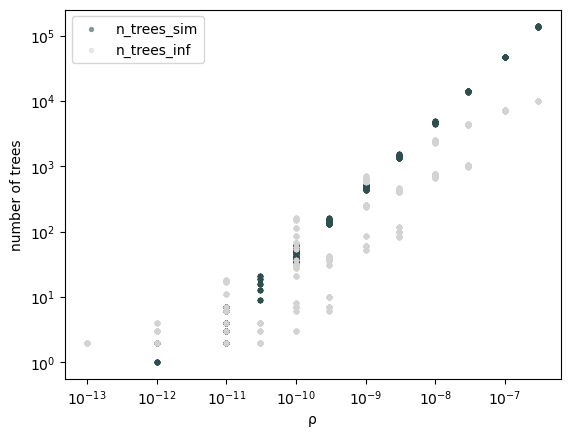

In [13]:
plt.figure()
plt.scatter(inf_all["rr"], inf_all['breakpoints_sim'], label="simulated", alpha = 0.5, c = 'darkslategrey', s = 8)
plt.scatter(inf_all["rr"], inf_all['breakpoints_sim'], label="inferred", alpha = 0.5, c = 'lightgrey', s =8)

plt.xlabel("ρ")
plt.ylabel("breakpoints")


#plt.xlim(7e-14, 4e-8)
plt.xscale("log") 
plt.gca().xaxis.set_minor_locator(ticker.NullLocator())
plt.yscale("log")
plt.gca().yaxis.set_minor_locator(ticker.NullLocator())

#plt.ylim(-100, )

plt.legend(loc = 'upper left')
plt.savefig("breakpoints_by_rho.png") 
plt.show()

In [14]:
inf_all["mu"].unique()

array([1.e-10, 1.e-09, 1.e-08, 1.e-07])

# collapsing all reps

In [17]:
null_s = null_all
inf_s = inf_all

In [22]:
# metric (mean, median) per-REP! 5 medians per p-m  

inf_s['median_r2'] = inf_all.groupby(['rr', 'mu', 'pm'])['r2'].transform('median')
inf_s['mean_r2'] = inf_all.groupby(['rr', 'mu','pm'])['r2'].transform('mean')
null_s['median_r2'] = null_all.groupby(['rr', 'mu', 'pm'])['r2'].transform('median')
null_s['mean_r2'] = null_all.groupby(['rr', 'mu', 'pm'])['r2'].transform('mean')

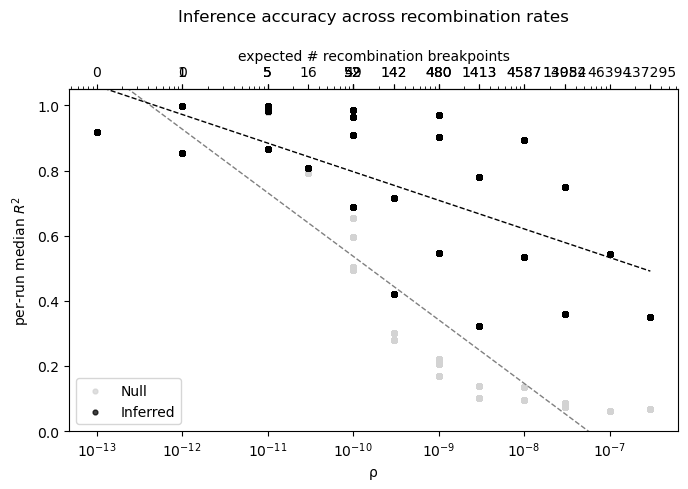

In [23]:
fig, ax = plt.subplots(figsize=(7,5))

# plot nulls 
if len(null_all):
    ax.scatter(
        null_s["rr"], null_s["median_r2"],
        s=12, alpha=0.75, c="lightgrey", label="Null"
    )
    m, b = np.polyfit(np.log(null_s["rr"]), null_s["median_r2"], 1)
    log_x_regression = np.linspace(min(np.log(null_s["rr"])), max(np.log(null_s["rr"])), 100)
    y_regression = m * log_x_regression + b
    plt.plot(np.exp(log_x_regression), y_regression, color='grey', linestyle='--', lw = 1)

# plot inferred results
if len(inf_all):
    ax.scatter(
        inf_s["rr"], inf_s["median_r2"],
        s=12, alpha=0.75, label="Inferred", c='black'
    )
    m, b = np.polyfit(np.log(inf_s["rr"]), inf_s["median_r2"], 1)
    log_x_regression = np.linspace(min(np.log(inf_s["rr"])), max(np.log(inf_s["rr"])), 100)
    y_regression = m * log_x_regression + b
    plt.plot(np.exp(log_x_regression), y_regression, color='black', linestyle='--', lw = 1)

# main x axis settings
ax.set_xscale("log")
plt.gca().xaxis.set_minor_locator(ticker.NullLocator())
#ax.set_xlim(7e-14, 1.5e-8)
ax.set_ylim(0, 1.05)

# secondary x axis w/ expected breakpoints -----
rr_vals = tree_counts.index.get_level_values("rr").values
bp_vals = tree_counts["expected_breakpoints"].values

secax = ax.secondary_xaxis("top")
secax.set_xticks(rr_vals)
secax.set_xticklabels([f"{bp:.0f}" for bp in bp_vals])
secax.set_xlabel("expected # recombination breakpoints")

# labels / title / legend
ax.set_xlabel("ρ")
ax.set_ylabel("per-run median $R^2$")
ax.set_title("Inference accuracy across recombination rates", fontsize=12, pad=20)
ax.legend(frameon=True, loc="lower left")

fig.tight_layout()
plt.show()

### plotting expected # breakpoints vs detectable # breakpoints (by mutation rate)

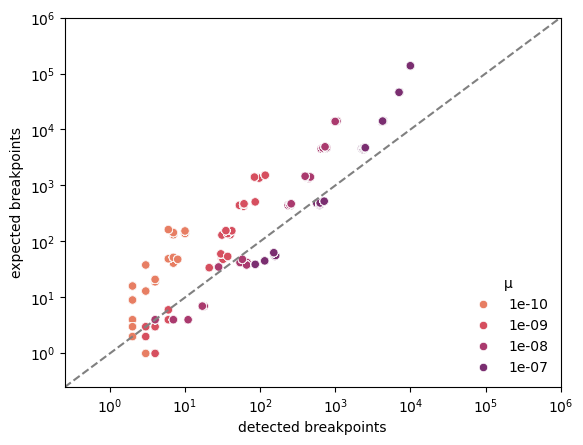

In [24]:
# y axis: expected number --  breakpoints_sim
# x axis: detectable number (color by mu) breakpoints_inf 

# bkpts = inf_all[


# plt.figure()
# plt.scatter(inf_all["breakpoints_sim"], inf_all["breakpoints_inf"], alpha = 0.5, c = 'darkslategrey', s = 8)
# plt.scatter(inf_all["rr"], inf_all["n_trees_inf"]-1, label="n_trees_inf", alpha = 0.5, c = 'lightgrey', s =8)

# plt.xlabel("ρ")
# plt.ylabel("number of trees")


# #plt.xlim(7e-14, 4e-8)
# plt.xscale("log") 
# plt.yscale("log")

# #plt.ylim(-100, )

# plt.legend(loc = 'upper left')
# plt.savefig("trees_by_rho.png") 
# plt.show()

bp_colors = sns.color_palette("flare", 4)

sns.scatterplot(data=inf_all, x='breakpoints_inf', y='breakpoints_sim', hue='mu', palette=bp_colors)
plt.axline([0, 0], slope=1, color='grey', linestyle='--')
plt.yscale('log')
plt.gca().yaxis.set_minor_locator(ticker.NullLocator())
plt.xscale('log')
plt.gca().xaxis.set_minor_locator(ticker.NullLocator())
plt.xlim(0.250, 10e5)
plt.ylim(0.250, 10e5)
plt.ylabel("expected breakpoints")
plt.xlabel("detected breakpoints")
plt.legend(title="μ", loc = 'lower right', frameon = False)
#plt.savefig("bp_detection_scatter.png")

plt.show()




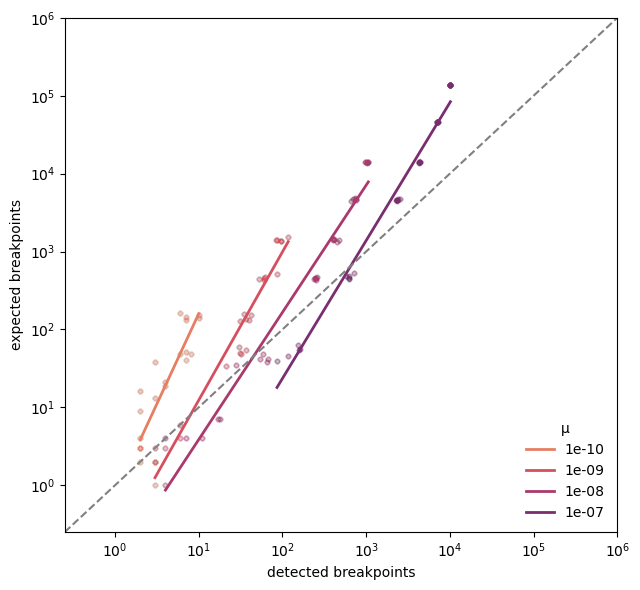

In [26]:
df = inf_all.copy()

mu_values = sorted(df["mu"].unique())

bp_colors = sns.color_palette("flare", len(mu_values))

plt.figure(figsize=(6.5, 6))

# points + trend lines by mu 
for mu, color in zip(mu_values, bp_colors):
    sub = df[df["mu"] == mu]
    if len(sub) == 0:
        continue

    # points (low alpha)
    plt.scatter(
        sub["breakpoints_inf"],
        sub["breakpoints_sim"],
        s=12,
        alpha=0.01,
        color=color
    )

    # trend line 
    if len(sub) >= 2:
        # keep only strictly positive values for log scale
        sub_fit = sub[(sub["breakpoints_inf"] > 0) & (sub["breakpoints_sim"] > 0)]
        if len(sub_fit) >= 2:
            lx = np.log10(sub_fit["breakpoints_inf"].to_numpy())
            ly = np.log10(sub_fit["breakpoints_sim"].to_numpy())
    
            m, b = np.polyfit(lx, ly, 1)
    
            xline = np.logspace(lx.min(), lx.max(), 200)
            yline = 10 ** (m * np.log10(xline) + b)
    
            plt.plot(xline, yline, lw=2, color=color, label=f"{mu:g}")

# y = x
plt.axline([1, 1], slope=1, color="grey", linestyle="--")

# --- formatting ---
plt.xscale("log")
plt.yscale("log")
plt.gca().xaxis.set_minor_locator(ticker.NullLocator())
plt.gca().yaxis.set_minor_locator(ticker.NullLocator())

plt.xlim(0.250, 1e6)
plt.ylim(0.250, 1e6)

plt.xlabel("detected breakpoints")
plt.ylabel("expected breakpoints", )
plt.legend(title="μ", loc = 'lower right', frameon = False)
plt.tight_layout()
#plt.savefig("bp_detection_trends.png")
plt.show()


### color by pm

In [ ]:
cmap = plt.get_cmap("mako")
pm_values = [0.001, 0.01, 0.1, 0.3, 1.0, 3.0]
colors = cmap(np.linspace(0, 1, len(pm_values)))

## median r2 (collapsed replicates)

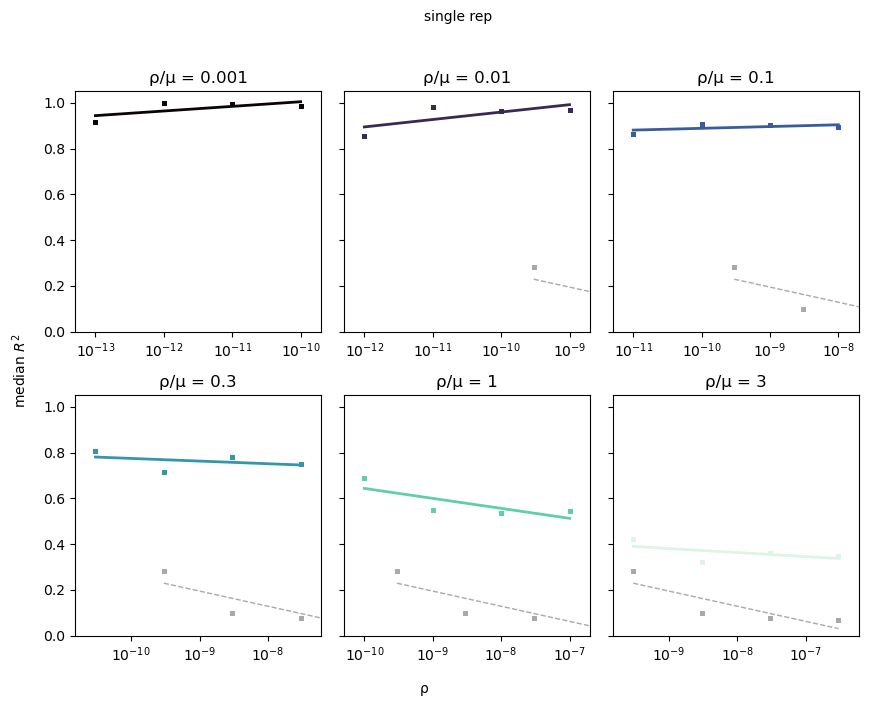

In [31]:
xlims = [(7e-14, 5e-6)] * len(pm_values)

fig, axes = plt.subplots(2, 3, figsize=(9, 7), sharex=False, sharey=True)

for ax, pm, color, xlim in zip(axes.flatten(), pm_values, colors, xlims):

    # subset by category (inf/null) 
    inf_sub = inf_s[inf_s["pm"] == pm]
    null_s[null_s["pm"] == pm]

    # plot null
    if len(null_sub):
        ax.scatter(
            null_sub["rr"], null_sub["median_r2"],
            s=5, alpha=0.75, color="darkgrey", label="null"
        )
        if len(null_sub) >= 2:
            m_null, b_null = np.polyfit(np.log(null_sub["rr"]), null_sub["median_r2"], 1)
            log_x_null = np.linspace(
                np.log(null_sub["rr"]).min(),
                np.log(null_sub["rr"]).max(),
                200
            )
            ax.plot(
                np.exp(log_x_null),
                m_null * log_x_null + b_null,
                color="darkgrey", linestyle="--", lw=1
            )

    # plot inf
    if len(inf_sub):
        ax.scatter(
            inf_sub["rr"], inf_sub["median_r2"],
            s=5, alpha=0.85, color=color, label="inferred"
        )
        if len(inf_sub) >= 2:
            m_inf, b_inf = np.polyfit(np.log(inf_sub["rr"]), inf_sub["median_r2"], 1)
            log_x_inf = np.linspace(
                np.log(inf_sub["rr"]).min(),
                np.log(inf_sub["rr"]).max(),
                200
            )
            ax.plot(
                np.exp(log_x_inf),
                m_inf * log_x_inf + b_inf,
                color=color, lw=2, label="fit"
            )

        # x lims
        xmin = inf_sub["rr"].min()
        xmax = inf_sub["rr"].max()
        ax.set_xlim(xmin * 0.5, xmax * 2.0)

    else:
        ax.set_xlim(xlim)

    # fmt
    ax.set_xscale("log")
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    ax.set_ylim(0, 1.05)
    ax.set_title(f"ρ/μ = {pm:g}")
    # ax.legend(frameon=True, fontsize=8, loc="lower left")

# shared labels
fig.text(0.5, 0.04, "ρ", ha="center")
fig.text(0.04, 0.5, "median $R^2$", va="center", rotation="vertical")


plt.tight_layout(rect=[0.06, 0.06, 1, 0.95])

#plt.savefig("median_rr_accuracy_facet_collapse.png")
plt.show()


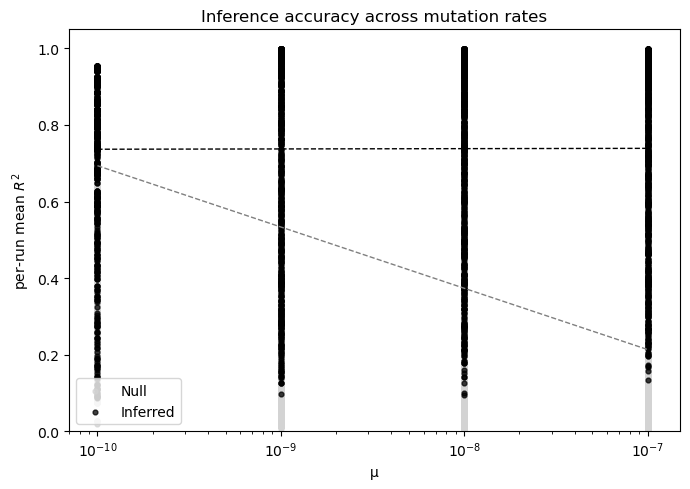

In [34]:
plt.figure(figsize=(7,5))

# plot nulls 
if len(null_all):
    m, b = np.polyfit(np.log(null_s["mu"]), null_s["r2"], 1)
    log_x_regression = np.linspace(min(np.log(null_s["mu"])), max(np.log(null_s["mu"])), 100)
    y_regression = m * log_x_regression + b
    #p = np.poly1d(z)
    plt.scatter(
        null_s["mu"], null_s["r2"],
        s=12, alpha=0.75, c="lightgrey", label="Null"
    )
    #plt.plot(null_s["mu"], m*null_s["mu"] + b, "--", color='grey')
    plt.plot(np.exp(log_x_regression), y_regression, color='grey', linestyle='--', lw=1)



# plot inferred results colored by rr (or rr_hat)
if len(inf_all):
    m, b = np.polyfit(np.log(inf_s["mu"]), inf_s["r2"], 1)
    log_x_regression = np.linspace(min(np.log(inf_s["mu"])), max(np.log(inf_s["mu"])), 100)
    y_regression = m * log_x_regression + b
    #cmap = plt.get_cmap("coolwarm")  # or "plasma", "coolwarm", etc.
    sc = plt.scatter(
        inf_s["mu"], inf_s["r2"],
        #c=inf_s["pm_true"],  # or inf_all["rr_hat"]
        #cmap=cmap,
        s=12, alpha=0.75, label="Inferred", c = 'black'
    )
    plt.plot(np.exp(log_x_regression), y_regression, color='black', linestyle='--', lw = 1)
    
    #plt.colorbar(sc, label="p/m")

plt.xlim(7e-11, 1.5e-7)
plt.xscale("log") 
#plt.xlabel([1e-10, 1e-9, 1e-8, 1e-7]) 
#plt.xticks(
plt.ylim(0,1.05)
plt.xlabel("μ")
plt.ylabel("per-run mean $R^2$")
plt.title("Inference accuracy across mutation rates")
plt.legend(frameon=True, loc="lower left")
plt.tight_layout()
#plt.savefig("mu_scatter_2.png") 
plt.show()

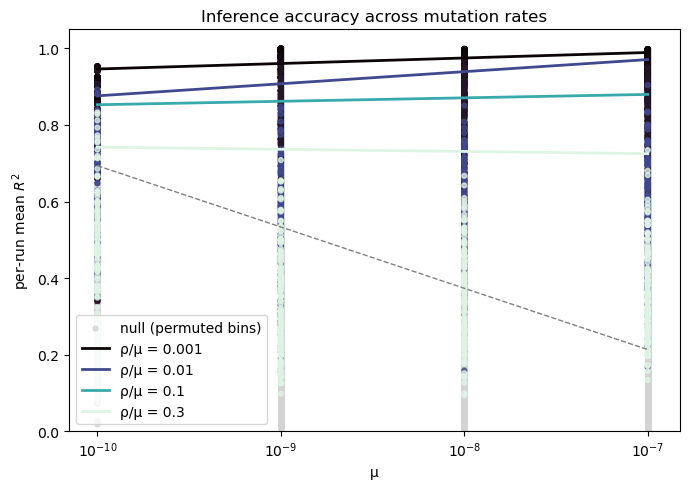

In [35]:
plt.figure(figsize=(7,5))

# colormap for different pm values 
cmap = plt.get_cmap("mako")
pm_values = [0.001, 0.01, 0.1, 0.3]
colors = cmap(np.linspace(0, 1, len(pm_values)))

# null pts
if len(null_all):
    plt.scatter(
        null_s["mu"], null_s["r2"],
        s=12, alpha=0.75, c="lightgrey", label="null (permuted bins)"
    )
    m, b = np.polyfit(np.log(null_s["mu"]), null_s["r2"], 1)
    log_x = np.linspace(min(np.log(null_s["mu"])), max(np.log(null_s["mu"])), 100)
    plt.plot(np.exp(log_x), m * log_x + b, color="grey", linestyle="--", lw=1)


# inf pts (colored by pm_true)
if len(inf_all):
    sc = plt.scatter(
        inf_s["mu"],
        inf_s["r2"],
        c=inf_s["pm"],
        cmap=cmap,
        s=12,
        alpha=0.75
    )
    #cbar = plt.colorbar(sc, label="p/m")

    # regression lines per pm 
    for pm, color in zip(pm_values, colors):
        subset = inf_s[inf_s["pm"] == pm]
        if len(subset) < 2:
            continue

        m, b = np.polyfit(np.log(subset["mu"]), subset["r2"], 1)
        log_x = np.linspace(
            min(np.log(subset["mu"])),
            max(np.log(subset["mu"])),
            200
        )
        y = m * log_x + b

        plt.plot(
            np.exp(log_x), y,
            color=color,
            lw=2,
            label=f"ρ/μ = {pm:g}"
        )

# axes/labels 
plt.xscale("log")
plt.gca().xaxis.set_minor_locator(ticker.NullLocator())
plt.xlim(7e-11, 1.5e-7)
plt.ylim(0, 1.05)
plt.xlabel("μ")
plt.ylabel("per-run mean $R^2$")
plt.title("Inference accuracy across mutation rates")
plt.legend(frameon=True, loc="lower left")
plt.tight_layout()
#plt.savefig("mu_accuracy.png")
plt.show()


# multiple reps 

In [36]:
# metric (mean, median) per-REP! 5 medians per p-m  
inf_s['median_r2'] = inf_all.groupby(['rr', 'mu', 'rep', 'pm'])['r2'].transform('median')
inf_s['mean_r2'] = inf_all.groupby(['rr', 'mu', 'rep', 'pm'])['r2'].transform('mean')
null_s['median_r2'] = null_all.groupby(['rr', 'mu', 'rep', 'pm'])['r2'].transform('median')
null_s['mean_r2'] = null_all.groupby(['rr', 'mu', 'rep', 'pm'])['r2'].transform('mean')

### breakpoints 

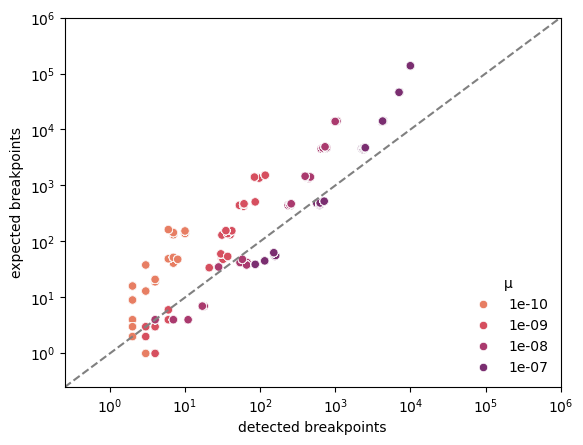

In [37]:
bp_colors = sns.color_palette("flare", 4)

sns.scatterplot(data=inf_all, x='breakpoints_inf', y='breakpoints_sim', hue='mu', palette=bp_colors)
plt.axline([0, 0], slope=1, color='grey', linestyle='--')
plt.yscale('log')
plt.gca().yaxis.set_minor_locator(ticker.NullLocator())
plt.xscale('log')
plt.gca().xaxis.set_minor_locator(ticker.NullLocator())
plt.xlim(0.250, 10e5)
plt.ylim(0.250, 10e5)
plt.ylabel("expected breakpoints")
plt.xlabel("detected breakpoints")
plt.legend(title="μ", loc = 'lower right', frameon = False)
#plt.savefig("bp_detection_scatter_5reps.png")

plt.show()




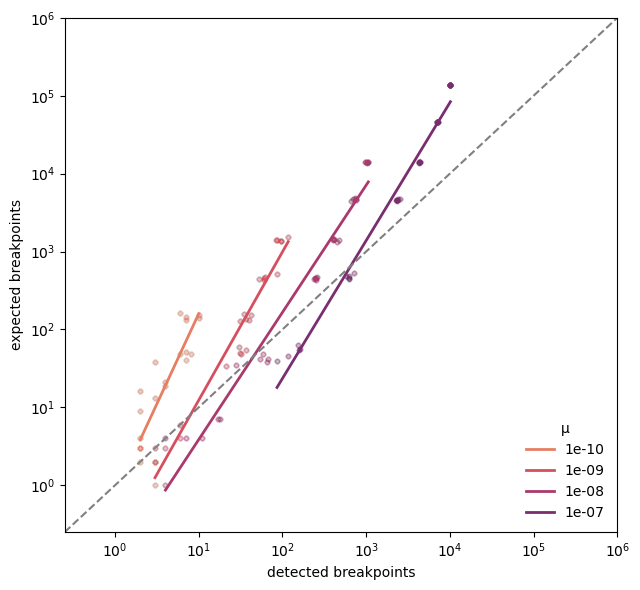

In [45]:
plt.figure(figsize=(6.5, 6))

# points + trend lines by mu 
for mu, color in zip(mu_values, bp_colors):
    sub = df[df["mu"] == mu]
    if len(sub) == 0:
        continue

    # points (low alpha)
    plt.scatter(
        sub["breakpoints_inf"],
        sub["breakpoints_sim"],
        s=12,
        alpha=0.01,
        color=color
    )

    # trend line 
    if len(sub) >= 2:
        # keep only strictly positive values for log scale
        sub_fit = sub[(sub["breakpoints_inf"] > 0) & (sub["breakpoints_sim"] > 0)]
        if len(sub_fit) >= 2:
            lx = np.log10(sub_fit["breakpoints_inf"].to_numpy())
            ly = np.log10(sub_fit["breakpoints_sim"].to_numpy())
    
            m, b = np.polyfit(lx, ly, 1)
    
            xline = np.logspace(lx.min(), lx.max(), 200)
            yline = 10 ** (m * np.log10(xline) + b)
    
            plt.plot(xline, yline, lw=2, color=color, label=f"{mu:g}")

# y = x
plt.axline([1, 1], slope=1, color="grey", linestyle="--")

# --- formatting ---
plt.xscale("log")
plt.yscale("log")
plt.gca().xaxis.set_minor_locator(ticker.NullLocator())
plt.gca().yaxis.set_minor_locator(ticker.NullLocator())

plt.xlim(0.250, 1e6)
plt.ylim(0.250, 1e6)

plt.xlabel("detected breakpoints")
plt.ylabel("expected breakpoints", )
plt.legend(title="μ", loc = 'lower right', frameon = False)
plt.tight_layout()
#plt.savefig("bp_detection_trends_5reps.png")
plt.show()


### one plot

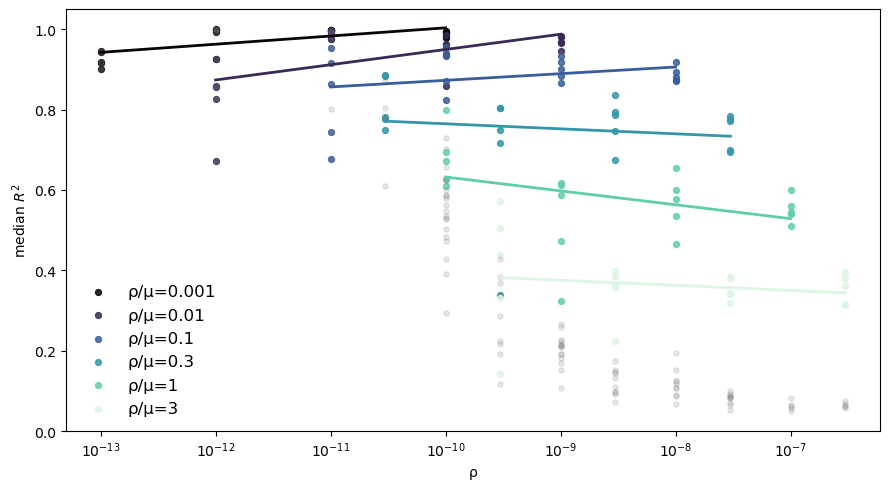

In [46]:
fig, ax = plt.subplots(figsize=(9, 5))

# colormap for different pm values
cmap = plt.get_cmap("mako")
pm_values = [0.001, 0.01, 0.1, 0.3, 1.0, 3.0]
colors = cmap(np.linspace(0, 1, len(pm_values)))

# inf
inf_fit = (inf_s
           .groupby(["pm", "rr", 'rep'], as_index=False)
           .agg(median_r2=("median_r2", "median")))

null_fit = (null_s
            .groupby(["pm", "rr", 'rep'], as_index=False)
            .agg(median_r2=("median_r2", "median")))

# plot by pm
for pm, color in zip(pm_values, colors):
    # inferred
    sub_i = inf_fit[np.isclose(inf_fit["pm"], pm)]
    if len(sub_i):
        ax.scatter(
            sub_i["rr"], sub_i["median_r2"],
            s=18, alpha=0.85, color=color,
            label=f"ρ/μ={pm:g}"
        )
        if len(sub_i) >= 2:
            lx = np.log(sub_i["rr"].to_numpy())
            y = sub_i["median_r2"].to_numpy()
            m, b = np.polyfit(lx, y, 1)
            log_x = np.linspace(lx.min(), lx.max(), 200)
            ax.plot(np.exp(log_x), m * log_x + b, color=color, lw=2)

    # null (same color, lower alpha)
    sub_n = null_fit[np.isclose(null_fit["pm"], pm)]
    if len(sub_n):
        ax.scatter(
            sub_n["rr"], sub_n["median_r2"],
            s=14, alpha=0.18, color='grey'#,
           # label=f"null ρ/μ={pm:g}"
        )

    # if len(null_all):
    #     ax.scatter(
    #         null_s["rr"], null_s["median_r2"],
    #         s=12, alpha=0.75, c="lightgrey", label="null (permuted bins)"
    #     )
        # if len(sub_n) >= 2:
        #     lx = np.log(sub_n["rr"].to_numpy())
        #     y = sub_n["median_r2"].to_numpy()
        #     m, b = np.polyfit(lx, y, 1)
        #     log_x = np.linspace(lx.min(), lx.max(), 200)
        #     ax.plot(np.exp(log_x), m * log_x + b, color=color, lw=1, ls="--", alpha=0.35)

# fmt
ax.set_xscale("log")
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.set_ylim(0, 1.05)

# x limits from inferred if available, else fallback to null
all_rr = inf_fit["rr"] if len(inf_fit) else null_fit["rr"]
ax.set_xlim(all_rr.min() * 0.5, all_rr.max() * 2.0)

ax.set_xlabel("ρ")
ax.set_ylabel("median $R^2$")


ax.legend(frameon=False, fontsize=12, loc="lower left", ncol=1)

fig.tight_layout()
#plt.savefig("rr_accuracy_single_bp_wide_5reps.png")
plt.show()


### facet

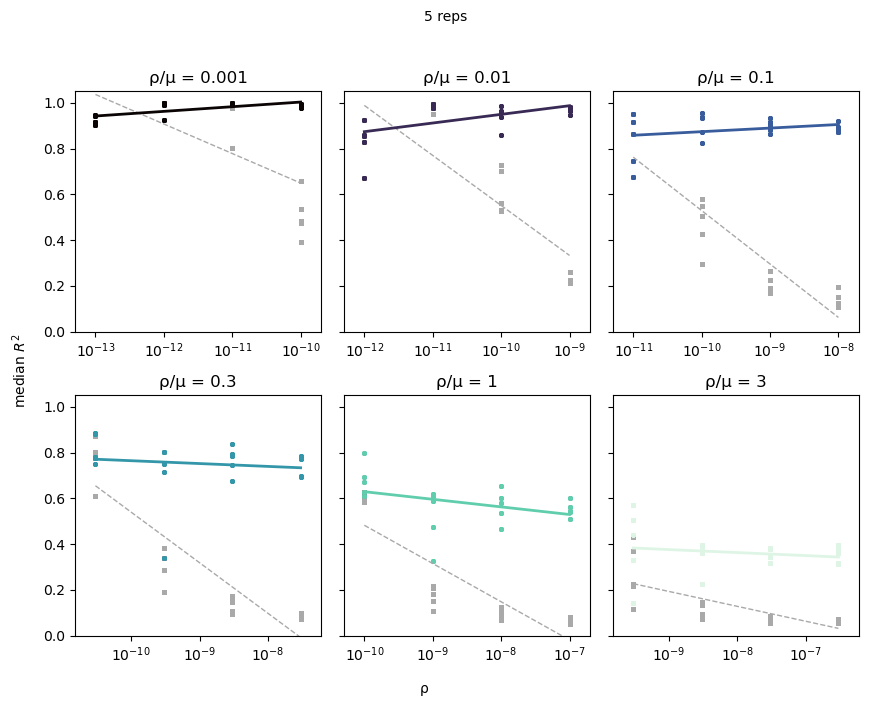

In [47]:
xlims = [(7e-14, 5e-6)] * len(pm_values)

fig, axes = plt.subplots(2, 3, figsize=(9, 7), sharex=False, sharey=True)

for ax, pm, color, xlim in zip(axes.flatten(), pm_values, colors, xlims):

    # subset by category (inf/null) 
    inf_sub = inf_s[inf_s["pm"] == pm]
    null_sub = null_s[null_s["pm"] == pm]

    # plot null
    if len(null_sub):
        ax.scatter(
            null_sub["rr"], null_sub["median_r2"],
            s=5, alpha=0.75, color="darkgrey", label="null"
        )
        if len(null_sub) >= 2:
            m_null, b_null = np.polyfit(np.log(null_sub["rr"]), null_sub["median_r2"], 1)
            log_x_null = np.linspace(
                np.log(null_sub["rr"]).min(),
                np.log(null_sub["rr"]).max(),
                200
            )
            ax.plot(
                np.exp(log_x_null),
                m_null * log_x_null + b_null,
                color="darkgrey", linestyle="--", lw=1
            )

    # plot inf
    if len(inf_sub):
        ax.scatter(
            inf_sub["rr"], inf_sub["median_r2"],
            s=5, alpha=0.85, color=color, label="inferred"
        )
        if len(inf_sub) >= 2:
            m_inf, b_inf = np.polyfit(np.log(inf_sub["rr"]), inf_sub["median_r2"], 1)
            log_x_inf = np.linspace(
                np.log(inf_sub["rr"]).min(),
                np.log(inf_sub["rr"]).max(),
                200
            )
            ax.plot(
                np.exp(log_x_inf),
                m_inf * log_x_inf + b_inf,
                color=color, lw=2, label="fit"
            )

        # x lims
        xmin = inf_sub["rr"].min()
        xmax = inf_sub["rr"].max()
        ax.set_xlim(xmin * 0.5, xmax * 2.0)

    else:
        ax.set_xlim(xlim)

    # fmt
    ax.set_xscale("log")
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    ax.set_ylim(0, 1.05)
    ax.set_title(f"ρ/μ = {pm:g}")
    # ax.legend(frameon=True, fontsize=8, loc="lower left")

# shared labels
fig.text(0.5, 0.04, "ρ", ha="center")
fig.text(0.04, 0.5, "median $R^2$", va="center", rotation="vertical")
fig.text(0.5, 1.0, "5 reps")


plt.tight_layout(rect=[0.06, 0.06, 1, 0.95])

#plt.savefig("median_rr_accuracy_facet_5reps.png")
plt.show()


# (C) Inference accuracy under fixed mutation rate and varying recombination rate. Points describing R2 values for null (permuted bins) are colored grey. 

/loc/scratch/47688978/ipykernel_12732/1269415889.py:30: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(lx, y, 1)
/loc/scratch/47688978/ipykernel_12732/1269415889.py:30: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(lx, y, 1)
/loc/scratch/47688978/ipykernel_12732/1269415889.py:30: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(lx, y, 1)
/loc/scratch/47688978/ipykernel_12732/1269415889.py:30: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(lx, y, 1)
/loc/scratch/47688978/ipykernel_12732/1269415889.py:30: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(lx, y, 1)
/loc/scratch/47688978/ipykernel_12732/1269415889.py:30: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(lx, y, 1)


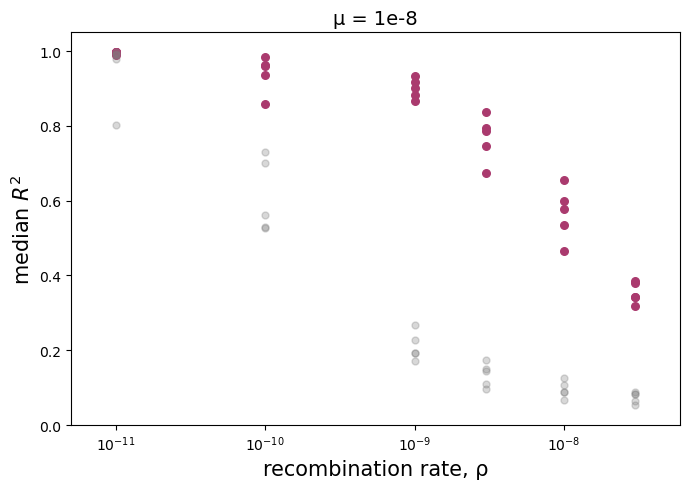

In [61]:
fig, ax = plt.subplots(figsize=(7, 5))

# colormap for different pm values
cmap = plt.get_cmap("mako")
pm_values = [0.001, 0.01, 0.1, 0.3, 1.0, 3.0]
colors = cmap(np.linspace(0, 1, len(pm_values)))

# aggregate so theres 1 row per (pm, rr) combo
inf_c = inf_s[inf_s['mu'] == 1e-8]
null_c = null_s[null_s['mu'] == 1e-8]

inf_fit = (inf_c.groupby(["pm", "rr", 'rep'], as_index=False).agg(median_r2=("median_r2", "median")))

null_fit = (null_c.groupby(["pm", "rr", 'rep'], as_index=False).agg(median_r2=("median_r2", "median")))


# plot per pm 
for pm, color in zip(pm_values, colors):
    # inferred
    sub_i = inf_fit[np.isclose(inf_fit["pm"], pm)]
    if len(sub_i):
        ax.scatter(
            sub_i["rr"], sub_i["median_r2"],
            s=30, alpha=1, color=bp_colors[2],
            label=f"ρ/μ={pm:g}"
        )
        if len(sub_i) >= 2:
            lx = np.log(sub_i["rr"].to_numpy())
            y = sub_i["median_r2"].to_numpy()
            m, b = np.polyfit(lx, y, 1)
            log_x = np.linspace(lx.min(), lx.max(), 200)
            ax.plot(np.exp(log_x), m * log_x + b, color=color, lw=2)

    # null (same color, lower alpha)
    sub_n = null_fit[np.isclose(null_fit["pm"], pm)]
    if len(sub_n):
        ax.scatter(
            sub_n["rr"], sub_n["median_r2"],
            s=25, alpha=0.3, color='grey'#,
           # label=f"null ρ/μ={pm:g}"
        )

    # if len(null_all):
    #     ax.scatter(
    #         null_s["rr"], null_s["median_r2"],
    #         s=12, alpha=0.75, c="lightgrey", label="null (permuted bins)"
    #     )
        # if len(sub_n) >= 2:
        #     lx = np.log(sub_n["rr"].to_numpy())
        #     y = sub_n["median_r2"].to_numpy()
        #     m, b = np.polyfit(lx, y, 1)
        #     log_x = np.linspace(lx.min(), lx.max(), 200)
        #     ax.plot(np.exp(log_x), m * log_x + b, color=color, lw=1, ls="--", alpha=0.35)

# fmt axes
ax.set_xscale("log")
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.set_ylim(0, 1.05)

# x limits from inferred, else use null
all_rr = inf_fit["rr"] if len(inf_fit) else null_fit["rr"]
ax.set_xlim(all_rr.min() * 0.5, all_rr.max() * 2.0)

ax.set_xlabel("recombination rate, ρ", fontsize=15)
ax.set_ylabel("median $R^2$", fontsize=15)

plt.title("μ = 1e-8", fontsize = 14)
#ax.legend(frameon=False, fontsize=12, loc="lower left", ncol=1)

fig.tight_layout()
#plt.savefig("figure_c.png")
plt.show()


/loc/scratch/47688978/ipykernel_12732/4099602596.py:30: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(lx, y, 1)
/loc/scratch/47688978/ipykernel_12732/4099602596.py:30: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(lx, y, 1)
/loc/scratch/47688978/ipykernel_12732/4099602596.py:30: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(lx, y, 1)
/loc/scratch/47688978/ipykernel_12732/4099602596.py:30: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(lx, y, 1)
/loc/scratch/47688978/ipykernel_12732/4099602596.py:30: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(lx, y, 1)
/loc/scratch/47688978/ipykernel_12732/4099602596.py:30: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(lx, y, 1)


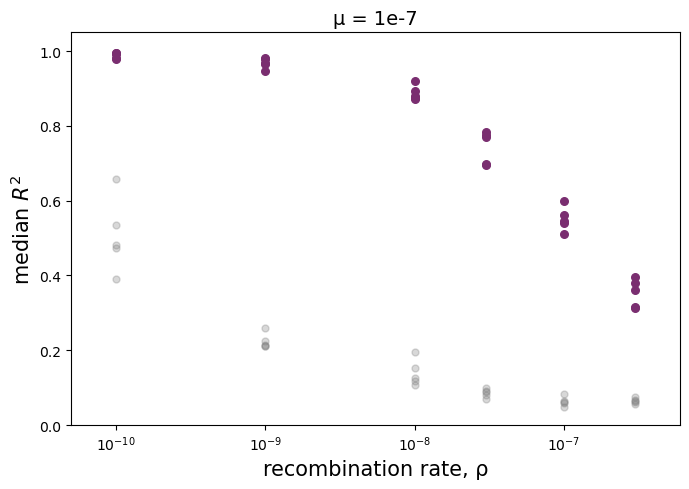

In [63]:
fig, ax = plt.subplots(figsize=(7, 5))

# colormap for different pm values
cmap = plt.get_cmap("mako")
pm_values = [0.001, 0.01, 0.1, 0.3, 1.0, 3.0]
colors = cmap(np.linspace(0, 1, len(pm_values)))

# aggregate so theres 1 row per (pm, rr) combo
inf_c = inf_s[inf_s['mu'] == 1e-7]
null_c = null_s[null_s['mu'] == 1e-7]

inf_fit = (inf_c.groupby(["pm", "rr", 'rep'], as_index=False).agg(median_r2=("median_r2", "median")))

null_fit = (null_c.groupby(["pm", "rr", 'rep'], as_index=False).agg(median_r2=("median_r2", "median")))


# plot per pm 
for pm, color in zip(pm_values, colors):
    # inferred
    sub_i = inf_fit[np.isclose(inf_fit["pm"], pm)]
    if len(sub_i):
        ax.scatter(
            sub_i["rr"], sub_i["median_r2"],
            s=30, alpha=1, color=bp_colors[3],
            label=f"ρ/μ={pm:g}"
        )
        if len(sub_i) >= 2:
            lx = np.log(sub_i["rr"].to_numpy())
            y = sub_i["median_r2"].to_numpy()
            m, b = np.polyfit(lx, y, 1)
            log_x = np.linspace(lx.min(), lx.max(), 200)
            ax.plot(np.exp(log_x), m * log_x + b, color=color, lw=2)

    # null (same color, lower alpha)
    sub_n = null_fit[np.isclose(null_fit["pm"], pm)]
    if len(sub_n):
        ax.scatter(
            sub_n["rr"], sub_n["median_r2"],
            s=25, alpha=0.3, color='grey'#,
           # label=f"null ρ/μ={pm:g}"
        )

    # if len(null_all):
    #     ax.scatter(
    #         null_s["rr"], null_s["median_r2"],
    #         s=12, alpha=0.75, c="lightgrey", label="null (permuted bins)"
    #     )
        # if len(sub_n) >= 2:
        #     lx = np.log(sub_n["rr"].to_numpy())
        #     y = sub_n["median_r2"].to_numpy()
        #     m, b = np.polyfit(lx, y, 1)
        #     log_x = np.linspace(lx.min(), lx.max(), 200)
        #     ax.plot(np.exp(log_x), m * log_x + b, color=color, lw=1, ls="--", alpha=0.35)

# fmt axes
ax.set_xscale("log")
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.set_ylim(0, 1.05)

# x limits from inferred, else use null
all_rr = inf_fit["rr"] if len(inf_fit) else null_fit["rr"]
ax.set_xlim(all_rr.min() * 0.5, all_rr.max() * 2.0)

ax.set_xlabel("recombination rate, ρ", fontsize=15)
ax.set_ylabel("median $R^2$", fontsize=15)

plt.title("μ = 1e-7", fontsize = 14)
#ax.legend(frameon=False, fontsize=12, loc="lower left", ncol=1)

fig.tight_layout()
#plt.savefig("figure_c_1e-7.png")
plt.show()
